In [1]:
# Notebook 5 — Data Visualizations (Monthly SR, 2x2 Heatmaps, Sankey, Partial Profiles)

import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.sankey import Sankey

# Ensure helper is importable and data present
sys.path.append('..')
from src.funnel_utils import normalize_events, attach_transfer_keys, build_transfer_level

exports_root = "../exports/visualizations"
os.makedirs(exports_root, exist_ok=True)

# Load or rebuild transfer-level dataset
events_path = "../data/wise_funnel_events.csv"
transfers_path = "../data/transfers_level.csv"

if not os.path.exists(transfers_path):
    raw = pd.read_csv(events_path, parse_dates=["dt"])
    df = normalize_events(raw, dt_col="dt")
    df = attach_transfer_keys(df, dt_col="dt")
    transfers = build_transfer_level(df, dt_col="dt")
    transfers.to_csv(transfers_path, index=False)
else:
    transfers = pd.read_csv(transfers_path, parse_dates=["created_dt","funded_dt","transferred_dt"])

# Success definition: everything not 'unsettled' counts as success
transfers["success_event"] = (transfers["status"] != "unsettled").astype(int)
transfers["failed_event"]  = (transfers["status"] == "unsettled").astype(int)

# Monthly buckets
transfers["created_month"] = transfers["created_dt"].dt.to_period("M").dt.to_timestamp()

/var/folders/ml/klt3p20j5xj8cgxtrxqrd6s00000gn/T/ipykernel_1937/3083484213.py:35: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  transfers["created_month"] = transfers["created_dt"].dt.to_period("M").dt.to_timestamp()


In [2]:

# 1) Monthly Success Rate (1 - Failure) per variable

def monthly_sr_by(col):
    df = transfers.groupby(["created_month", col], dropna=False).agg(
        success_rate=("success_event","mean"),
        total=("transfer_id","count")
    ).reset_index().sort_values(["created_month", col])
    # 7-day MA isn't meaningful monthly; we keep monthly only here.
    return df

for col in ["region","experience","platform"]:
    m = monthly_sr_by(col)
    out_csv = os.path.join(exports_root, f"monthly_success_rate_by_{col}.csv")
    m.to_csv(out_csv, index=False)

    # Line plot per category
    plt.figure()
    for key, sub in m.groupby(col, dropna=False):
        plt.plot(sub["created_month"], sub["success_rate"], label=str(key))
    plt.title(f"Monthly Success Rate by {col.capitalize()}")
    plt.xlabel("Month")
    plt.ylabel("Success Rate")
    plt.xticks(rotation=45)
    plt.legend(title=col.capitalize())
    plt.tight_layout()
    plt.savefig(os.path.join(exports_root, f"monthly_success_rate_by_{col}.png"), dpi=180)
    plt.close()


In [3]:

# 2) 2x2 Heatmaps (gradient) — average FAILURE rate to spot friction
# We compute overall (all months) failure rate per cross, and also month-level if needed.

def cross_failure(idx, col):
    tmp = transfers.groupby([idx, col], dropna=False).agg(
        failure_rate=("failed_event","mean"),
        n=("transfer_id","count")
    ).reset_index()
    pivot = tmp.pivot(index=idx, columns=col, values="failure_rate")
    return pivot

crosses = [
    ("region","platform"),
    ("region","experience"),
    ("platform","experience")
]

for idx, col in crosses:
    pivot = cross_failure(idx, col)
    out_csv = os.path.join(exports_root, f"failure_rate_{idx}_by_{col}.csv")
    pivot.to_csv(out_csv)

    # Heatmap-style visualization (no explicit colors set)
    plt.figure()
    plt.imshow(pivot.values, aspect="auto")
    plt.colorbar()
    plt.xticks(ticks=range(pivot.shape[1]), labels=[str(c) for c in pivot.columns], rotation=45)
    plt.yticks(ticks=range(pivot.shape[0]), labels=[str(i) for i in pivot.index])
    plt.title(f"Failure Rate: {idx} × {col} (lower is better)")
    plt.tight_layout()
    plt.savefig(os.path.join(exports_root, f"failure_rate_{idx}_by_{col}.png"), dpi=180)
    plt.close()


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


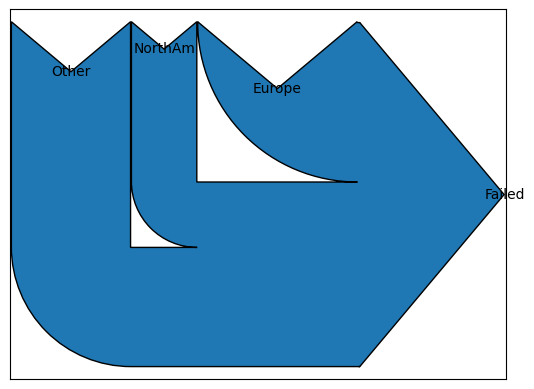

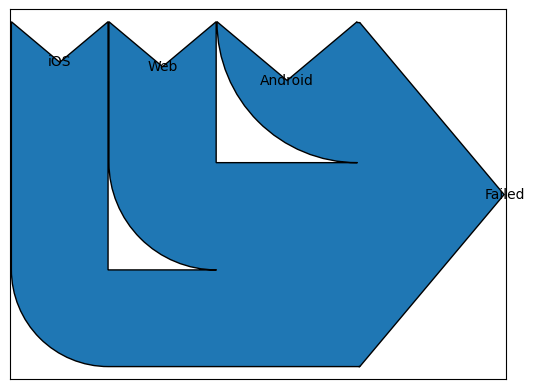

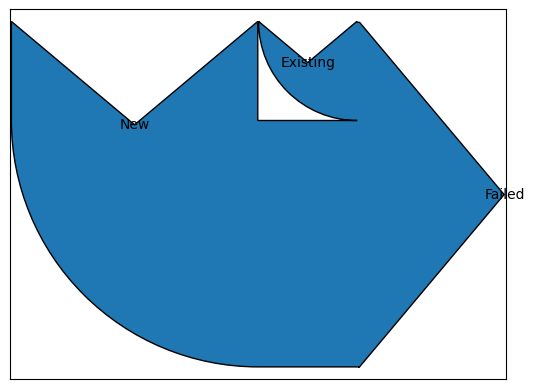

In [4]:

# 3) Decomposition of failed processes — Sankey per dimension
# "Of each 100 failed transactions, how many come from each group"
# We'll implement separate Sankeys for Region, Platform, Experience

def sankey_failed_by(col, filename_png):
    df = transfers.groupby(col, dropna=False)["failed_event"].sum().reset_index()
    total_failed = df["failed_event"].sum()
    if total_failed == 0:
        print(f"No failed events for {col}, skipping Sankey.")
        return
    df["share"] = df["failed_event"] / total_failed
    # Scale flows to 100 (each 100 failed transactions)
    flows = (df["share"] * 100).values
    labels = df[col].astype(str).tolist()

    # Matplotlib Sankey expects flows that sum to ~0. We'll create a central node that receives positives and sends out -100.
    sankey = Sankey(unit=None)
    sankey.add(flows=np.r_[flows, -flows.sum()],  # in from groups, out to sink
               labels=labels + ["Failed"],
               orientations=[1]*len(flows) + [0])
    fig = plt.figure()
    sankey.finish()
    plt.title(f"Decomposition of Failed Transactions — {col.capitalize()} (per 100 fails)")
    plt.tight_layout()
    plt.savefig(os.path.join(exports_root, filename_png), dpi=180)
    plt.close()

for col in ["region","platform","experience"]:
    sankey_failed_by(col, f"sankey_failed_by_{col}.png")


In [6]:

# 4) Partially-settled analysis — where it happens and profile differences

part = transfers[transfers["status"] == "partially_settled"].copy()

# Distribution by segments
dist = {}
for col in ["region","platform","experience"]:
    d = part.groupby(col, dropna=False).size().div(len(part)).fillna(0).reset_index(name="share")
    d.to_csv(os.path.join(exports_root, f"partially_settled_share_by_{col}.csv"), index=False)
    dist[col] = d

# Compare success vs partial profiles: compute rates per segment
def rate_table(col):
    base = transfers.groupby(col, dropna=False).size().reset_index(name="n")
    partials = part.groupby(col, dropna=False).size().reset_index(name="partials")
    settled = transfers[transfers["status"]=="settled"].groupby(col, dropna=False).size().reset_index(name="settled")
    out = base.merge(partials, on=col, how="left").merge(settled, on=col, how="left").fillna(0)
    out["partial_rate"] = out["partials"] / out["n"]
    out["settled_rate"] = out["settled"] / out["n"]
    out.to_csv(os.path.join(exports_root, f"partial_vs_settled_rates_by_{col}.csv"), index=False)
    return out

for col in ["region","platform","experience"]:
    rate_table(col)

# Simple bars for partial rates (one chart per col)
for col in ["region","platform","experience"]:
    tbl = pd.read_csv(os.path.join(exports_root, f"partial_vs_settled_rates_by_{col}.csv"))
    plt.figure()
    plt.bar(tbl[col].astype(str), tbl["partial_rate"])
    plt.title(f"Partially Settled Rate by {col.capitalize()}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(exports_root, f"partial_rate_by_{col}.png"), dpi=180)
    plt.close()

print("Visualization assets written to:", exports_root)


Visualization assets written to: ../exports/visualizations
